# Basic Linear Regression Model - Real Estate Price Prediction

This notebook builds a basic linear regression model to predict property prices (total price in millions VND) using the processed alonhadat dataset.

## 1. Import Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

## 2. Load Data

In [39]:
# Load the preprocessed data
df = pd.read_csv('../../Data Preprocessing/alonhadat_processed.csv')
# Drop unnecessary columns
df.drop(columns=['date', 'is_price_per_m2'], inplace=True) 

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (14426, 15)

First few rows:


,address,area,bedrooms,floors,price,title,road,ward,district,address_complete,road_cat,ward_cat,district_cat,price_converted,price_per_m2
0,"Đường Nguyễn Văn Cừ, Phường Gia Thụy, Quận Lon...",80,1,1,"7,5 tỷ","🥇ĐẤT NGUYỄN VĂN CỪ 80M, MT8M, MẢNH ĐẤT RỘNG TH...",Nguyễn Văn Cừ,Gia Thụy,Long Biên,1,564,54,11,7500.00,93.75
1,"Đường Ngọc Lâm, Phường Ngọc Lâm, Quận Long Biê...",36,3,6,"8,65 tỷ","🔥CÒN DUY NHẤT 1 CĂN GIÁ RẺ, NGỌC LÂM 36M, 6T G...",Ngọc Lâm,Ngọc Lâm,Long Biên,1,603,157,11,8650.00,240.28
2,"Đường Ngô Gia Tự, Phường Đức Giang, Quận Long ...",56,1,1,"15,5 tỷ","👉MẶT PHỐ, NGÔ GIA TỰ, 56M, MT4M, VỈA HÈ ĐÁ BÓN...",Ngô Gia Tự,Đức Giang,Long Biên,1,587,390,11,15500.00,276.79
3,"Đường Phúc Lợi, Phường Phúc Lợi, Quận Long Biê...",32,3,5,"5,2 tỷ","🥇CĂN DUY NHẤT, NGÕ THÔNG, Ô TÔ , LÔ GÓC, PHÚC ...",Phúc Lợi,Phúc Lợi,Long Biên,1,667,193,11,5200.00,162.50
4,"Phố Lệ Mật, Phường Việt Hưng, Quận Long Biên, ...",58,3,3,7 tỷ,"🏡VIỆT HƯNG, DIỆN TÍCH RỘNG 58m, 3T, MT5m GIÁ C...",Lệ Mật,Việt Hưng,Long Biên,1,445,313,11,7000.00,120.69


In [40]:
# Check data types and missing values
print("\nData types and missing values:")
df.info()

# Display descriptive statistics for numeric columns
print("\nDescriptive statistics:")
df.describe()


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14426 entries, 0 to 14425
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   address           14426 non-null  object 
 1   area              14426 non-null  int64  
 2   bedrooms          14426 non-null  int64  
 3   floors            14426 non-null  int64  
 4   price             14426 non-null  object 
 5   title             14426 non-null  object 
 6   road              14260 non-null  object 
 7   ward              14410 non-null  object 
 8   district          14426 non-null  object 
 9   address_complete  14426 non-null  int64  
 10  road_cat          14426 non-null  int64  
 11  ward_cat          14426 non-null  int64  
 12  district_cat      14426 non-null  int64  
 13  price_converted   14426 non-null  float64
 14  price_per_m2      14426 non-null  float64
dtypes: float64(2), int64(7), object(6)
memory usage: 1.7+ M

,area,bedrooms,floors,address_complete,road_cat,ward_cat,district_cat,price_converted,price_per_m2
count,14426.00,14426.00,14426.00,14426.00,14426.00,14426.00,14426.00,14426.00,14426.00
mean,57.46,4.22,4.64,0.99,582.51,193.47,12.61,13134.79,228.73
std,26.51,1.67,1.48,0.11,315.48,110.17,8.56,8247.17,92.59
min,6.00,1.00,1.00,0.00,-1.00,-1.00,1.00,0.00,0.00
25%,40.00,3.00,4.00,1.00,348.00,109.00,6.00,6980.00,167.32
50%,50.00,4.00,5.00,1.00,572.00,177.00,10.00,10500.00,216.01
75%,68.00,5.00,5.00,1.00,848.00,294.50,22.00,17400.00,285.71
max,181.00,10.00,9.00,1.00,1144.00,392.00,28.00,42400.00,483.87


## 3. Feature Selection and Data Preparation

Let's select relevant features for our model. We'll use a combination of numeric and categorical features.

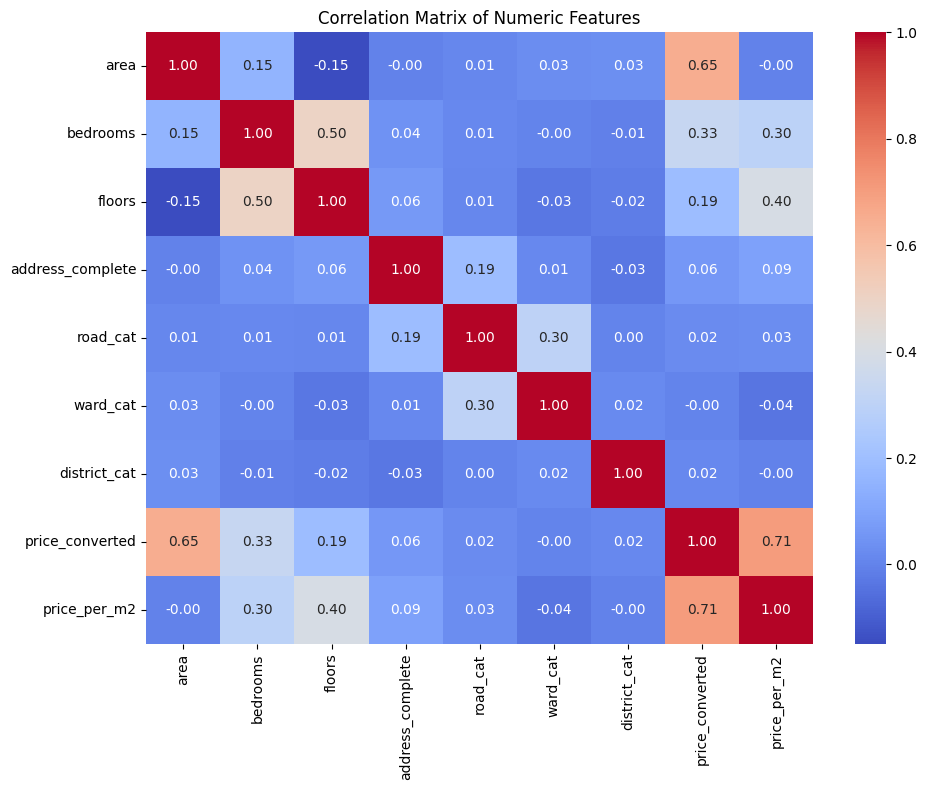

Correlations with price_converted:
price_converted     1.00
price_per_m2        0.71
area                0.65
bedrooms            0.33
floors              0.19
address_complete    0.06
road_cat            0.02
district_cat        0.02
ward_cat           -0.00
Name: price_converted, dtype: float64


In [41]:
# Examine correlations with price_converted
plt.figure(figsize=(10, 8))
correlation_matrix = df.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

# Print correlations with price_converted
price_correlations = correlation_matrix['price_converted'].sort_values(ascending=False)
print("Correlations with price_converted:")
print(price_correlations)

In [42]:
# Select features for modeling with enhanced feature engineering
# Create derived features to capture more complex relationships

# Create additional engineered features
df['bedroom_per_area'] = df['bedrooms'] / df['area']  # Bedrooms density
df['is_corner'] = df['title'].str.contains('GÓC|GÓCH?', case=False, regex=True).astype(int)  # Corner property indicator
df['is_main_road'] = df['title'].str.contains('MẶT PHỐ|MẶT TIỀN|MẶT ĐƯỜNG', case=False, regex=True).astype(int)  # Main road indicator
df['has_car_access'] = df['title'].str.contains('Ô TÔ|OTO|XE HƠI', case=False, regex=True).astype(int)  # Car access indicator

# Create district groups based on price levels
district_price = df.groupby('district')['price_converted'].median().sort_values()
price_percentiles = np.percentile(district_price, [33, 66])
price_labels = ['low_price', 'mid_price', 'high_price']
district_price_category = pd.cut(district_price, 
                                bins=[0] + list(price_percentiles) + [float('inf')], 
                                labels=price_labels)
district_to_price_category = dict(zip(district_price.index, district_price_category))
df['district_price_category'] = df['district'].map(district_to_price_category)

# Expanded numeric features with engineered features
numeric_features = ['area', 'bedrooms', 'floors', 'bedroom_per_area', 'is_main_road',
                   'is_corner', 'has_car_access']

# Categorical features - use price category instead of just district
categorical_features = ['district_price_category']

# Define features and target
X = df[numeric_features + categorical_features].copy()
y = df['price_converted']  # Use total price as target instead of price per m2

print("Feature set shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature set sample:")
X.head()

Feature set shape: (14426, 8)
Target shape: (14426,)

Feature set sample:


,area,bedrooms,floors,bedroom_per_area,is_main_road,is_corner,has_car_access,district_price_category
0,80,1,1,0.01,0,0,0,high_price
1,36,3,6,0.08,0,1,1,high_price
2,56,1,1,0.02,1,0,0,high_price
3,32,3,5,0.09,0,1,1,high_price
4,58,3,3,0.05,0,0,1,high_price


## 4. Data Preprocessing Pipeline

Create a preprocessing pipeline that handles both numeric and categorical features:
1. Standard scaling for numeric features
2. One-hot encoding for categorical features

In [43]:
# Create improved preprocessing pipelines for both numeric and categorical data
from sklearn.preprocessing import RobustScaler, PowerTransformer

# Enhanced numeric transformer with options for dealing with skewed data and outliers
numeric_transformer = Pipeline(steps=[
    ('power', PowerTransformer(method='yeo-johnson', standardize=False)),  # Better handles skewed features
    ('scaler', RobustScaler())  # Less sensitive to outliers than StandardScaler
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the preprocessing and training pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Display the preprocessing pipeline
print("Enhanced Preprocessing Pipeline:")
print(preprocessor)

Enhanced Preprocessing Pipeline:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('power',
                                                  PowerTransformer(standardize=False)),
                                                 ('scaler', RobustScaler())]),
                                 ['area', 'bedrooms', 'floors',
                                  'bedroom_per_area', 'is_main_road',
                                  'is_corner', 'has_car_access']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['district_price_category'])])


## 5. Split Data and Train Model

In [44]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Train the model
model_pipeline.fit(X_train, y_train)

# Get the trained model
model = model_pipeline.named_steps['regressor']

# Display model coefficients
feature_names = (
    numeric_features +
    model_pipeline.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_features).tolist()
)

coefficients = pd.DataFrame(
    model.coef_,
    index=feature_names,
    columns=['Coefficient']
).sort_values(by='Coefficient', ascending=False)

# print("\nModel Coefficients:")
# print(coefficients)
# print(f"\nIntercept: {model.intercept_:.2f}")

Training set shape: (12983, 8)
Testing set shape: (1443, 8)


## 6. Model Evaluation

In [45]:
from scipy import stats
# Make predictions
y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

# Calculate additional evaluation metrics including MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print("Linear Regression Model Performance:")
print(f"Training R² Score: {train_r2:.4f}")
print(f"Testing R² Score: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.2f} million VND")
print(f"Testing RMSE: {test_rmse:.2f} million VND")
print(f"Training MAE: {train_mae:.2f} million VND")
print(f"Testing MAE: {test_mae:.2f} million VND")
print(f"Training MAPE: {train_mape:.2f}%")
print(f"Testing MAPE: {test_mape:.2f}%")

# Analyze outliers in residuals
residuals = y_test - y_test_pred
z_scores = np.abs(stats.zscore(residuals))
outlier_threshold = 3
outlier_indices = np.where(z_scores > outlier_threshold)[0]
print(f"\nNumber of outlier predictions: {len(outlier_indices)} ({len(outlier_indices)/len(residuals)*100:.2f}%)")

# Calculate performance without outliers
if len(outlier_indices) > 0:
    clean_indices = np.where(z_scores <= outlier_threshold)[0]
    y_test_clean = y_test.iloc[clean_indices]
    y_test_pred_clean = y_test_pred[clean_indices]
    
    # Calculate metrics without outliers
    test_r2_clean = r2_score(y_test_clean, y_test_pred_clean)
    test_rmse_clean = np.sqrt(mean_squared_error(y_test_clean, y_test_pred_clean))
    test_mae_clean = mean_absolute_error(y_test_clean, y_test_pred_clean)
    test_mape_clean = mean_absolute_percentage_error(y_test_clean, y_test_pred_clean)
    
    print("\nModel Performance Without Outliers:")
    print(f"Testing R² Score: {test_r2_clean:.4f} (Improvement: {(test_r2_clean-test_r2)*100:.2f}%)")
    print(f"Testing RMSE: {test_rmse_clean:.2f} million VND (Improvement: {(test_rmse-test_rmse_clean)/test_rmse*100:.2f}%)")
    print(f"Testing MAE: {test_mae_clean:.2f} million VND (Improvement: {(test_mae-test_mae_clean)/test_mae*100:.2f}%)")
    print(f"Testing MAPE: {test_mape_clean:.2f}% (Improvement: {(test_mape-test_mape_clean)/test_mape*100:.2f}%)")

Linear Regression Model Performance:
Training R² Score: 0.5831
Testing R² Score: 0.6003
Training RMSE: 5331.19 million VND
Testing RMSE: 5157.74 million VND
Training MAE: 3905.24 million VND
Testing MAE: 3761.83 million VND
Training MAPE: 4894104.10%
Testing MAPE: 39.37%

Number of outlier predictions: 17 (1.18%)

Model Performance Without Outliers:
Testing R² Score: 0.6380 (Improvement: 3.77%)
Testing RMSE: 4742.01 million VND (Improvement: 8.06%)
Testing MAE: 3579.79 million VND (Improvement: 4.84%)
Testing MAPE: 38.58% (Improvement: 2.01%)


## 7. Visualize Results

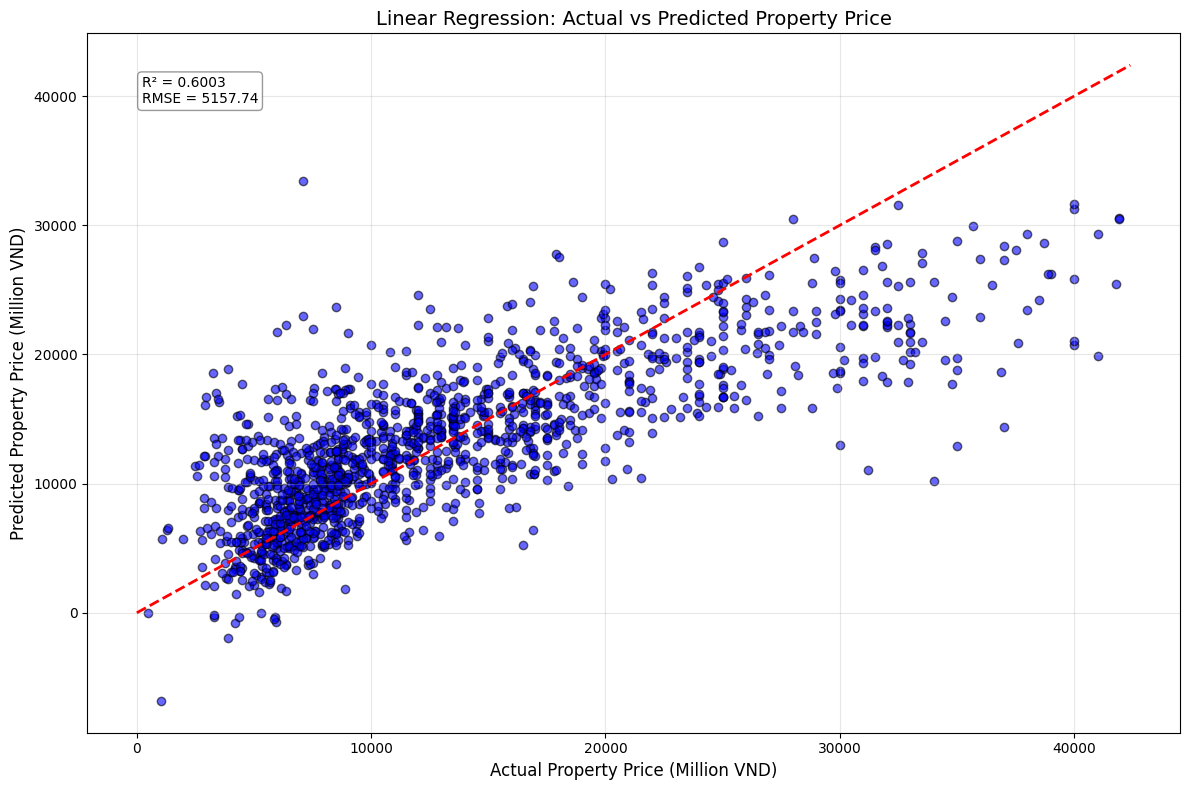

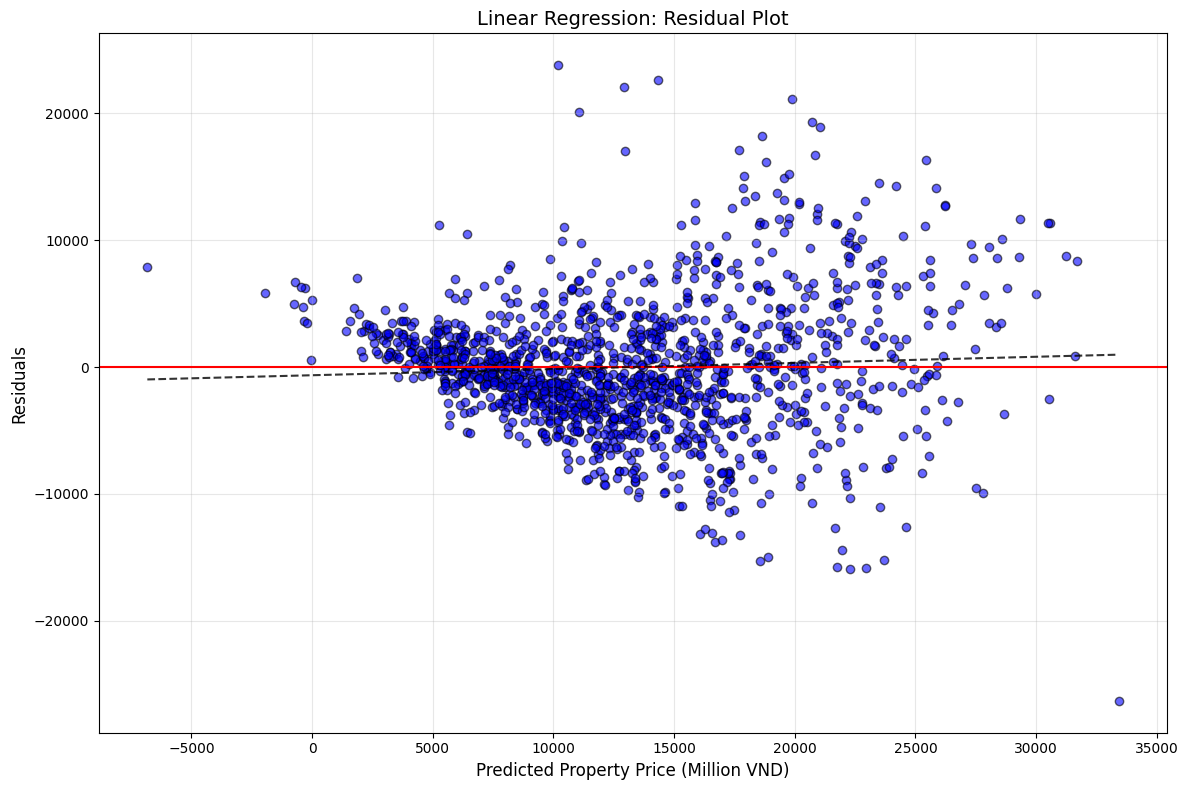

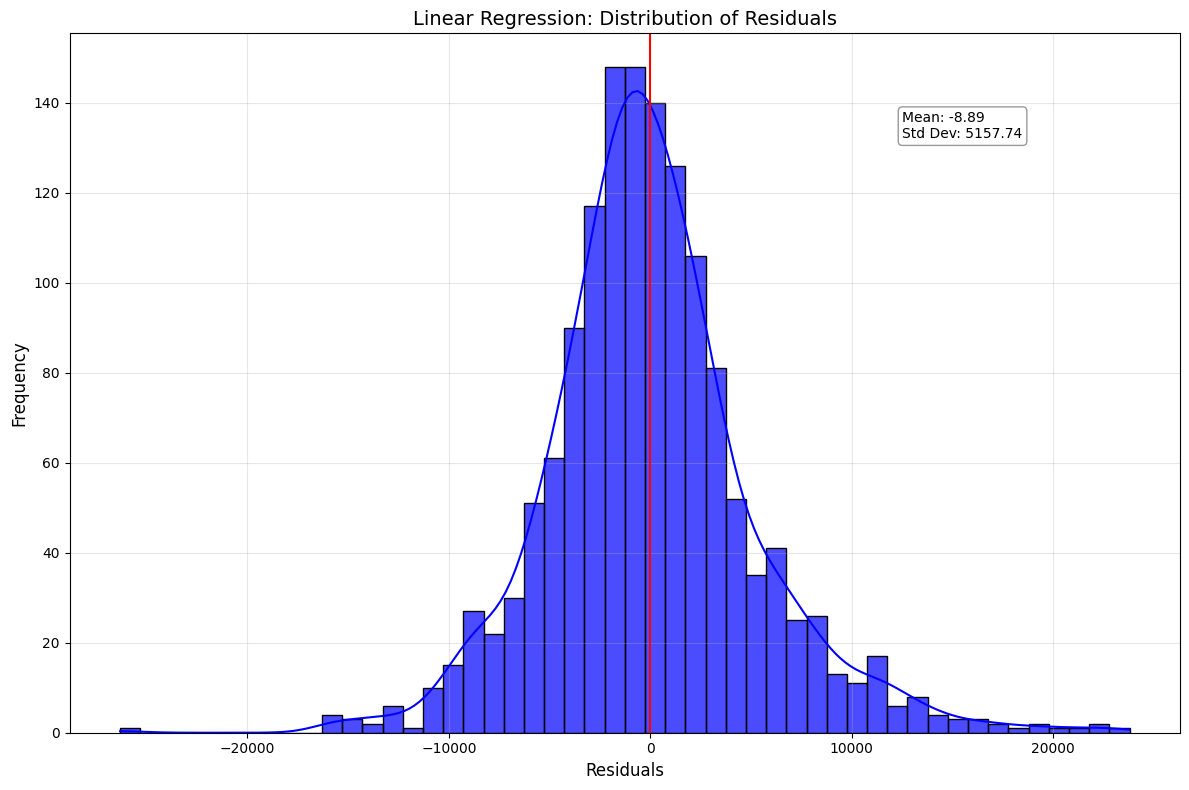

<Figure size 1000x800 with 0 Axes>

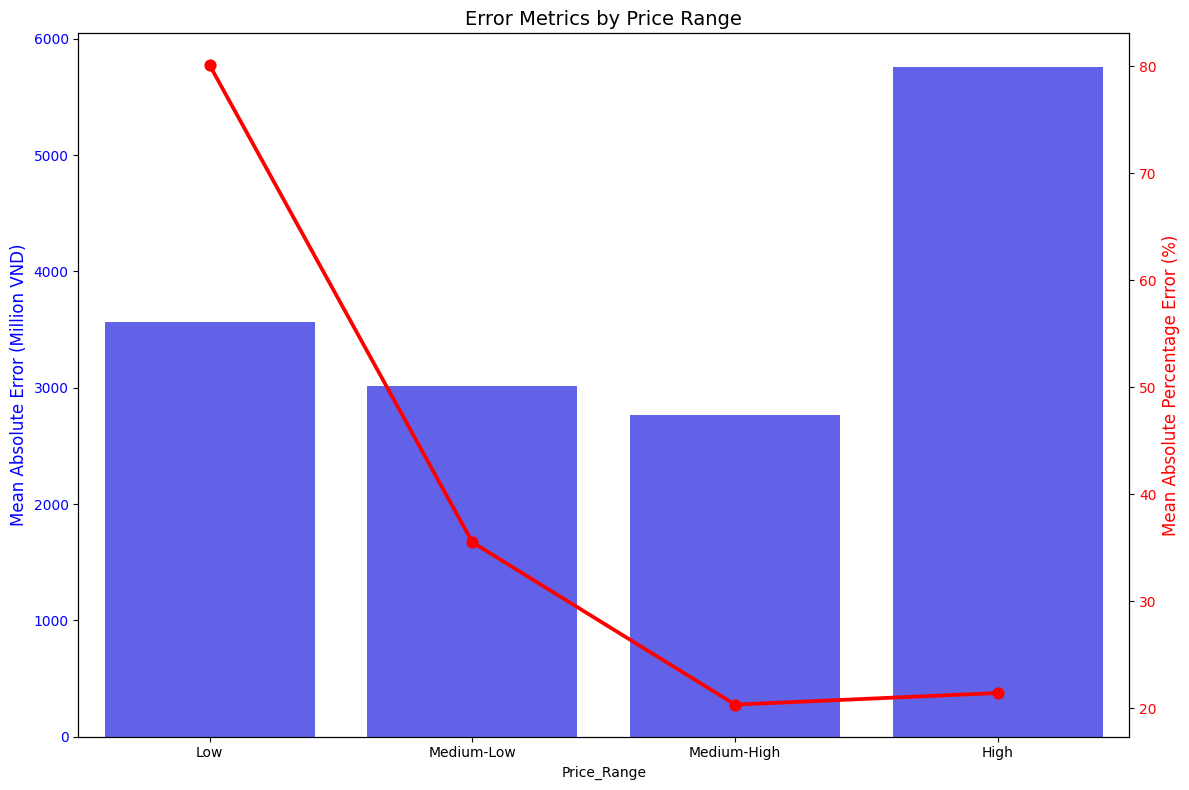

In [46]:
# Visualize predictions vs actual values with enhanced formatting
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_test_pred, alpha=0.6, c='blue', edgecolors='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Property Price (Million VND)', fontsize=12)
plt.ylabel('Predicted Property Price (Million VND)', fontsize=12)
plt.title('Linear Regression: Actual vs Predicted Property Price', fontsize=14)
plt.grid(True, alpha=0.3)

# Add annotations for R² and RMSE
plt.annotate(f"R² = {test_r2:.4f}\nRMSE = {test_rmse:.2f}", 
             xy=(0.05, 0.9), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.tight_layout()
plt.show()

# Plot residuals with improved visualization
residuals = y_test - y_test_pred
plt.figure(figsize=(12, 8))
plt.scatter(y_test_pred, residuals, alpha=0.6, c='blue', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Property Price (Million VND)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Linear Regression: Residual Plot', fontsize=14)
plt.grid(True, alpha=0.3)

# Add trend line for residuals
z = np.polyfit(y_test_pred, residuals, 1)
p = np.poly1d(z)
plt.plot(np.sort(y_test_pred), p(np.sort(y_test_pred)), "k--", alpha=0.8)
plt.tight_layout()
plt.show()

# Histogram of residuals with KDE and improved formatting
plt.figure(figsize=(12, 8))
sns.histplot(residuals, kde=True, bins=50, color='blue', alpha=0.7)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Linear Regression: Distribution of Residuals', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='r', linestyle='-')

# Annotate with statistics
plt.annotate(f"Mean: {np.mean(residuals):.2f}\nStd Dev: {np.std(residuals):.2f}", 
             xy=(0.75, 0.85), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.tight_layout()
plt.show()

# Create a price range analysis
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

results_df['Price_Range'] = pd.qcut(results_df['Actual'], 4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
price_range_mae = results_df.groupby('Price_Range').apply(lambda x: mean_absolute_error(x['Actual'], x['Predicted']))
price_range_mape = results_df.groupby('Price_Range').apply(lambda x: mean_absolute_percentage_error(x['Actual'], x['Predicted']))

plt.figure(figsize=(10, 8))
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

sns.barplot(x=price_range_mae.index, y=price_range_mae.values, ax=ax1, alpha=0.7, color='blue')
ax1.set_ylabel('Mean Absolute Error (Million VND)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

sns.pointplot(x=price_range_mape.index, y=price_range_mape.values, ax=ax2, color='red')
ax2.set_ylabel('Mean Absolute Percentage Error (%)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Error Metrics by Price Range', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

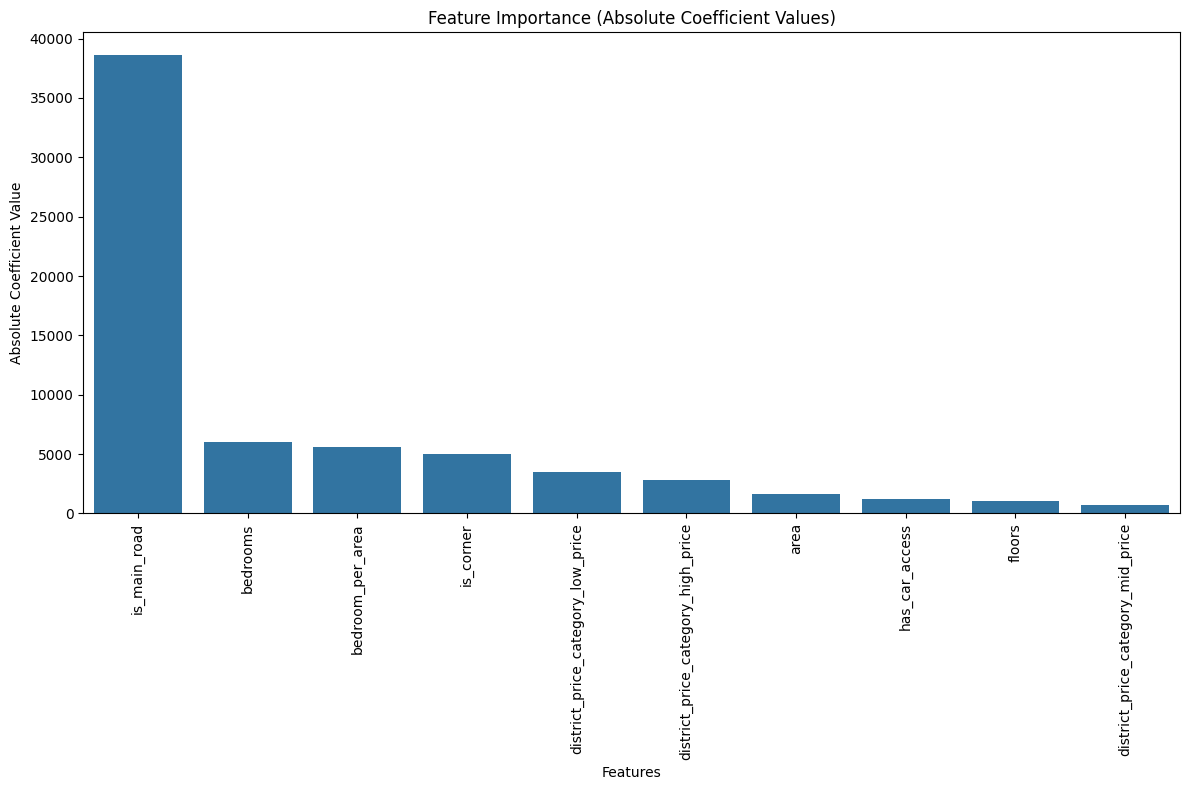

In [47]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
coefficients_abs = coefficients.abs().sort_values(by='Coefficient', ascending=False)
sns.barplot(x=coefficients_abs.index, y=coefficients_abs['Coefficient'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Absolute Coefficient Value')
plt.title('Feature Importance (Absolute Coefficient Values)')
plt.tight_layout()
plt.show()

## 9. Polynomial Regression Model

Let's try polynomial regression to capture non-linear relationships in our data. Polynomial regression can potentially improve model performance by creating polynomial features (e.g., squared, cubed) from the original features.

In [48]:
# Create a polynomial regression pipeline
# We'll create polynomial features for our numeric features
poly_numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scaler', StandardScaler())
])

# Keep the same categorical transformer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
poly_preprocessor = ColumnTransformer(
    transformers=[
        ('num', poly_numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the preprocessing and training pipeline
poly_model_pipeline = Pipeline(steps=[
    ('preprocessor', poly_preprocessor),
    ('regressor', LinearRegression())
])

print("Polynomial Regression Pipeline:")
print(poly_preprocessor)

Polynomial Regression Pipeline:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('poly',
                                                  PolynomialFeatures(degree=5,
                                                                     include_bias=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['area', 'bedrooms', 'floors',
                                  'bedroom_per_area', 'is_main_road',
                                  'is_corner', 'has_car_access']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['district_price_category'])])


## 10. Regularization: Ridge and Lasso Regression

To improve model performance and reduce overfitting, let's try Ridge and Lasso regression, which add regularization to the linear model.

In [ ]:
from sklearn.linear_model import Ridge, Lasso

# Ridge Regression
ridge_model_pipeline = Pipeline(steps=[
    ('preprocessor', poly_preprocessor),
    ('regressor', Ridge(alpha=1.0, random_state=42, max_iter=10000))
])
ridge_model_pipeline.fit(X_train, y_train)
ridge_train_pred = ridge_model_pipeline.predict(X_train)
ridge_test_pred = ridge_model_pipeline.predict(X_test)
ridge_train_r2 = r2_score(y_train, ridge_train_pred)
ridge_test_r2 = r2_score(y_test, ridge_test_pred)
ridge_train_rmse = np.sqrt(mean_squared_error(y_train, ridge_train_pred))
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, ridge_test_pred))
ridge_train_mae = mean_absolute_error(y_train, ridge_train_pred)
ridge_test_mae = mean_absolute_error(y_test, ridge_test_pred)

# Lasso Regression
lasso_model_pipeline = Pipeline(steps=[
    ('preprocessor', poly_preprocessor),
    ('regressor', Lasso(alpha=0.1, random_state=42, max_iter=10000))
])
lasso_model_pipeline.fit(X_train, y_train)
lasso_train_pred = lasso_model_pipeline.predict(X_train)
lasso_test_pred = lasso_model_pipeline.predict(X_test)
lasso_train_r2 = r2_score(y_train, lasso_train_pred)
lasso_test_r2 = r2_score(y_test, lasso_test_pred)
lasso_train_rmse = np.sqrt(mean_squared_error(y_train, lasso_train_pred))
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, lasso_test_pred))
lasso_train_mae = mean_absolute_error(y_train, lasso_train_pred)
lasso_test_mae = mean_absolute_error(y_test, lasso_test_pred)